In [1]:
import tensorflow as tf
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, Conv1D, MaxPool1D, Flatten, UpSampling1D, AveragePooling1D#, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.python.keras import utils
from tensorflow.keras.callbacks import TensorBoard

In [3]:
path_to_dataset = '../dataset/N_DATA'

In [4]:
def load_dataset():
    x, y = [], []
    directory = os.fsencode(path_to_dataset)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        pos = filename.find('_')
        label = filename[pos+1:-4]
        data = []
        with open(path_to_dataset+'/'+filename, newline='') as f:
            reader = csv.reader(f, delimiter=';')
            data = [[float(y) for y in x] for x in list(reader)]
        data = np.array(data).T.tolist()
        data.pop(0)
        data.pop(-1)
        x.append(np.array(data).flatten())
        y.append(int(label))
    return np.array(x), np.array(y)

In [5]:
'''
Стандартная загрузка
'''
x, y = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(411, 2807) (137, 2807) (411,) (137,)


In [6]:
input_layer = Input(shape=(2807,))

encoded = Dense(3*64, activation='elu')(input_layer)
encoded = Dense(2*64, activation='elu')(encoded)
encoded = Dense(64, activation='elu')(encoded)

encoded_input = Input(shape=(64,))
decoded = Dense(2*64, activation='elu')(encoded_input)
decoded = Dense(3*64, activation='elu')(decoded)
decoded = Dense(2807, activation='sigmoid')(decoded)

encoder_model = Model(input_layer, encoded)
decoder_model = Model(encoded_input, decoded)
autoencoder_model = Model(input_layer, decoder_model(encoder_model(input_layer)))

In [7]:
# tf.keras.backend.clear_session()
autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder_model.fit(x_train, x_train,
                                  epochs=160,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0,
                                  validation_data=(x_test, x_test))
print(history.history['val_loss'][-1])

0.2224980741739273


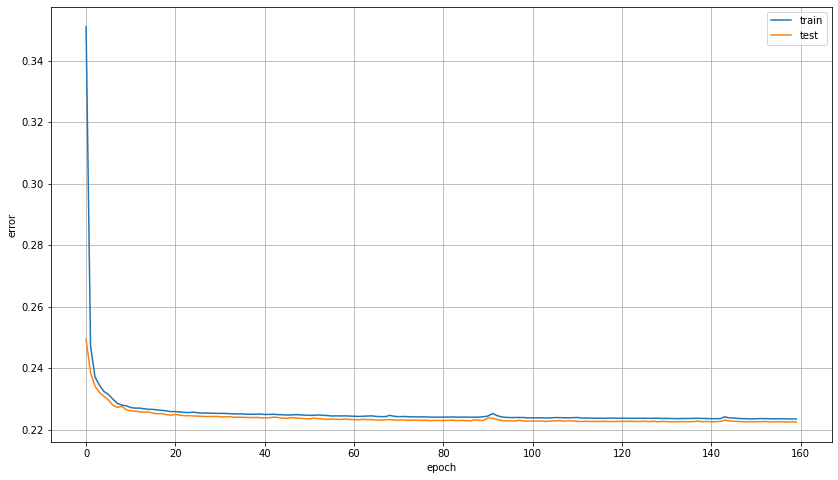

In [8]:
plt.figure(figsize=(14, 8))
plt.grid()
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [7]:
# autoencoder_model.save_weights("weights.h5")
load_status = autoencoder_model.load_weights('weights.h5')

In [8]:
def plot_sp(sample):
    plt.figure(figsize=(12, 8))
    plt.grid()
    labels = ['405','458','476','488','496','514','543']
    
    assert len(sample) == 2807
    x = list(range(-200, 201))
    y = np.array(sample).reshape((7, 401))
    
    for label, current_sp in enumerate(y):
        plt.plot(x, current_sp, label=labels[label])
        
    plt.legend()
    plt.show()

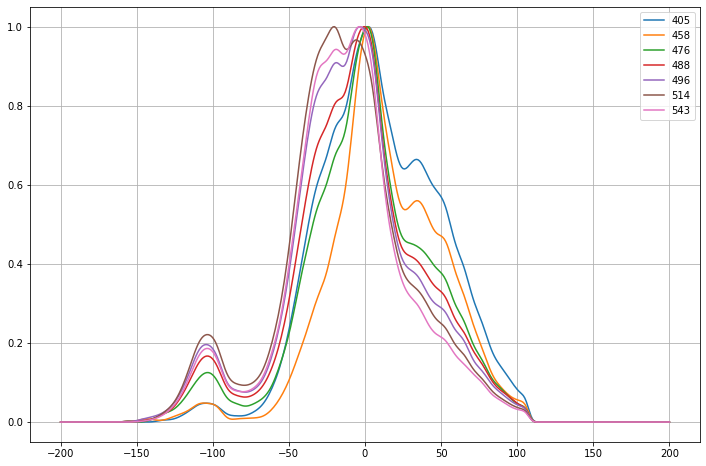

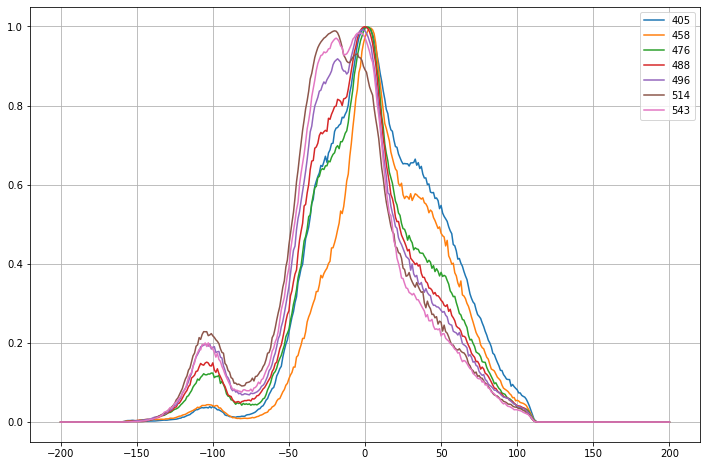

In [12]:
sample = np.array(x_train[23]).reshape(((1, 2807)))
prediction = autoencoder_model(sample, training=False).numpy().flatten()

plot_sp(x_train[23])
plot_sp(prediction)

# Классификация

- Метод k-ближайших соседей (K-Nearest Neighbors);
- Метод опорных векторов (Support Vector Machines);
- Классификатор дерева решений (Decision Tree Classifier) / Случайный лес (Random Forests);
- Наивный байесовский метод (Naive Bayes);
- Линейный дискриминантный анализ (Linear Discriminant Analysis);

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import sklearn

In [11]:
transformed_x = []
for datapoint in x:
    current = np.array(datapoint).reshape(((1, 2807)))
    transformed_x.append(encoder_model(current, training=False).numpy().flatten())

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print(encoder.classes_)

x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)

print(np.asarray(x_train).shape,
      np.asarray(x_test).shape,
      np.asarray(y_train).shape,
      np.asarray(y_test).shape)

[ 398  457  535  550  601  624  666  756  824 1072 1126 1315 1336 1409
 1415 1416 1712 1713 1715 1718 1750 1763 1804 1817]
(411, 64) (137, 64) (411,) (137,)


### Метод k-ближайших соседей
Этот метод работает с помощью поиска кратчайшей дистанции между тестируемым объектом и ближайшими к нему классифицированным объектами из обучающего набора. 
Классификация на основе соседей - это тип ленивого обучения, поскольку она не пытается построить общую внутреннюю модель, а просто хранит экземпляры обучающих данных. Классификация вычисляется на основе простого большинства голосов k ближайших соседей каждой точки.

Преимущества: Этот алгоритм прост в реализации, устойчив к зашумленным обучающим данным и эффективен при большом объеме обучающих данных.

Недостатки: Необходимость определения значения K и высокая стоимость вычислений, так как необходимо вычислять расстояние от каждого экземпляра до всех обучающих образцов.

In [44]:
acc = []
f = []
prec = []
rec = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(x_train, y_train)
    knn_prediction = knn.predict(x_test)
    
    acc.append(accuracy_score(knn_prediction, y_test))
    precision, recall, fbeta, _ = sklearn.metrics.precision_recall_fscore_support(y_test, knn_prediction, average='macro')
#     print(precision, recall, fbeta)
    f.append(fbeta)
    prec.append(precision)
    rec.append(recall)

print(np.sum(acc) / 10)
print(np.sum(prec) / 10)
print(np.sum(rec) / 10)
print(np.sum(f) / 10)

0.8328467153284672
0.7874825868575869
0.7879094516594517
0.7719644371662224


S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\

### Метод опорных векторов

Машина опорных векторов - это представление обучающих данных в виде точек в пространстве, разделенных на категории как можно более широким промежутком. Новые примеры затем отображаются в это же пространство и предсказывают принадлежность к той или иной категории на основе того, по какую сторону разрыва они попадают.

Преимущества: Эффективен в пространствах высокой размерности и использует подмножество обучающих точек в функции принятия решений, поэтому также экономит память.

Недостатки: Алгоритм не дает прямых оценок вероятности, они вычисляются с помощью дорогостоящей пятикратной перекрестной валидации.

In [52]:
acc = []
f = []
prec = []
rec = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)
    svm = SVC(kernel='linear')
    svm.fit(x_train, y_train)
    svm_prediction = svm.predict(x_test)
    acc.append(accuracy_score(svm_prediction, y_test))
    precision, recall, fbeta, _ = sklearn.metrics.precision_recall_fscore_support(y_test, svm_prediction, average='macro')
#     print(precision, recall, fbeta)
    f.append(fbeta)
    prec.append(precision)
    rec.append(recall)

print(np.sum(acc) / 10)
print(np.sum(prec) / 10)
print(np.sum(rec) / 10)
print(np.sum(f) / 10)

0.8883211678832119
0.8551124685499687
0.8642313011063012
0.8524014481194536


S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\

### Случайный лес
Классификатор Random forest - это мета-оценщик, который настраивает несколько деревьев решений на различных подвыборках наборов данных и использует среднее значение для улучшения предсказательной точности модели и контроля переобучения. Размер подвыборки всегда такой же, как и размер исходной входной выборки, но выборки берутся с заменой.

Преимущества: Уменьшение переобучения, и классификатор случайного леса в большинстве случаев более точен, чем деревья решений.

Недостатки: Медленное прогнозирование в реальном времени, сложность реализации и сложный алгоритм.

In [55]:
acc = []
f = []
prec = []
rec = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)
    rfm = RandomForestClassifier()
    rfm.fit(x_train, y_train)
    rfm_prediction = rfm.predict(x_test)
    acc.append(accuracy_score(rfm_prediction, y_test))
    precision, recall, fbeta, _ = sklearn.metrics.precision_recall_fscore_support(y_test, rfm_prediction, average='macro')
#     print(precision, recall, fbeta)
    f.append(fbeta)
    prec.append(precision)
    rec.append(recall)

print(np.sum(acc) / 10)
print(np.sum(prec) / 10)
print(np.sum(rec) / 10)
print(np.sum(f) / 10)

S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\

0.8854014598540145
0.8454735195360195
0.8378439153439153
0.8330169702124627


S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Наивный байесовский метод
Алгоритм Наивного Байеса основан на теореме Байеса с предположением о независимости между каждой парой признаков. Классификаторы Naive Bayes хорошо работают во многих реальных ситуациях, таких как классификация документов и фильтрация спама.

Преимущества: Этот алгоритм требует небольшого количества обучающих данных для оценки необходимых параметров. Классификаторы Naive Bayes чрезвычайно быстры по сравнению с более сложными методами.

Недостатки: Наивный Байес - не самый эффективный классификатор.

In [59]:
acc = []
f = []
prec = []
rec = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)
    nb = GaussianNB()
    nb.fit(x_train, y_train)
    nb_prediction = nb.predict(x_test)
    acc.append(accuracy_score(nb_prediction, y_test))
    precision, recall, fbeta, _ = sklearn.metrics.precision_recall_fscore_support(y_test, nb_prediction, average='macro')
#     print(precision, recall, fbeta)
    f.append(fbeta)
    prec.append(precision)
    rec.append(recall)

print(np.sum(acc) / 10)
print(np.sum(prec) / 10)
print(np.sum(rec) / 10)
print(np.sum(f) / 10)

0.8445255474452555
0.8097919281834723
0.7877822871572872
0.7882557166123819


S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\

### Линейный дискриминантный анализ

In [64]:
acc = []
f = []
prec = []
rec = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(transformed_x,
                                                    encoded_y,
                                                    test_size=0.25,
                                                    stratify=encoded_y)
    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)
    lda_prediction = lda.predict(x_test)
    acc.append(accuracy_score(lda_prediction, y_test))
    precision, recall, fbeta, _ = sklearn.metrics.precision_recall_fscore_support(y_test, lda_prediction, average='macro')
#     print(precision, recall, fbeta)
    f.append(fbeta)
    prec.append(precision)
    rec.append(recall)

print(np.sum(acc) / 10)
print(np.sum(prec) / 10)
print(np.sum(rec) / 10)
print(np.sum(f) / 10)

0.8737226277372263
0.8667443667443667
0.8754392135642135
0.8543862676841713


S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\

|                                 | Accuracy (доля правильных ответов) | Precision (Точность) | Recall (полнота) | F1   |
|---------------------------------|------------------------------------|----------------------|------------------|------|
| Метод k-ближайших соседей       | 86.86%                             | 0.89                 | 0.87             | 0.87 |
| Метод опорных векторов          | 91.97%                             | 0.93                 | 0.92             | 0.92 |
| Случайный лес                   | 89.78%                             | 0.91                 | 0.90             | 0.90 |
| Наивный байесовский метод       | 85.40%                             | 0.88                 | 0.85             | 0.86 |
| Линейный дискриминантный анализ | 87.59%                             | 0.90                 | 0.88             | 0.87 |

SVM хорошо работает в пространствах большой размерности, потому и самый лучший результат

Наивный байес работает быстрее остальных методов, но ниже по точности

k-ближайших очень простой и сильно зависит от k, поэтому тоже не самый хороший результат

Слуяайный лес и ЛДА работают средне, но все равно с достаточной точностью